## Import necessary packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import hdf5plugin
import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix
from CellPLM.utils import set_seed
from CellPLM.pipeline.cell_embedding import CellEmbeddingPipeline
import scanpy as sc
import matplotlib.pyplot as plt
import rapids_singlecell as rsc  # For faster evaluation, we recommend the installation of rapids_singlecell.

## Specify important parameters before getting started

In [2]:
PRETRAIN_VERSION = '20231027_85M'
DEVICE = 'cuda:0'

## Load Downstream Dataset

The example dataset here is from [GSE155468](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE155468).


In [3]:
set_seed(42)

data = ad.read_h5ad('../data/gse155468.h5ad')
data.obs_names_make_unique()

## Set up the pipeline

In [4]:
pipeline = CellEmbeddingPipeline(pretrain_prefix=PRETRAIN_VERSION, # Specify the pretrain checkpoint to load
                                 pretrain_directory='../ckpt')
pipeline.model

OmicsFormer(
  (embedder): OmicsEmbeddingLayer(
    (act): ReLU()
    (norm0): GroupNorm(4, 1024, eps=1e-05, affine=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (extra_linear): Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): GroupNorm(4, 1024, eps=1e-05, affine=True)
    )
    (pe_enc): Sinusoidal2dPE(
      (pe_enc): Embedding(10000, 1024)
    )
    (feat_enc): OmicsEmbedder()
  )
  (mask_model): MaskBuilder()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): FlowformerLayer(
        (self_attn): Flow_Attention(
          (query_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (key_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (value_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (out_projection): Linear(in_features=1024, out_features=1024, bias=True)
          (drop

## Evaluation and Inference

Once the pipeline is initialized, performing inference (cell embedding query) or evaluation on new datasets (with clustering metrics) can be easily accomplished using the built-in `predict` and `score` functions.

INFO:biothings.client:querying 1-1000...


Automatically converting gene symbols to ensembl ids...


INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-12382...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists 

After filtering, 10000 genes remain.


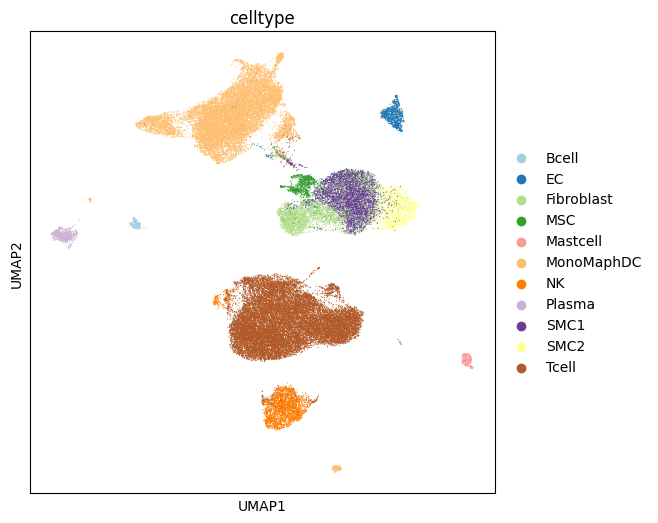

In [5]:
embedding = pipeline.predict(data, # An AnnData object
                device=DEVICE) # Specify a gpu or cpu for model inference

data.obsm['emb'] = embedding.cpu().numpy()
sc.pp.neighbors(data, use_rep='emb', method='rapids') # remove method='rapids' if rapids is not installed
sc.tl.umap(data, method='rapids') # remove method='rapids' if rapids is not installed
plt.rcParams['figure.figsize'] = (6, 6)
sc.pl.umap(data, color='celltype', palette='Paired')

In [ ]:
pipeline.score(data, # An AnnData object
               label_fields=['celltype'],
               evaluation_config = {
                   'method': 'scanpy', # change to 'scanpy' if 'rapids_singlecell' is not installed; the final scores may vary due to the implementation
                   'batch_size': 50000, # Specify batch size to limit gpu memory usage
               },
               device=DEVICE) # Specify a gpu or cpu for model inference

INFO:biothings.client:querying 1-1000...


Automatically converting gene symbols to ensembl ids...


INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-4000...
INFO:biothings.client:done.
INFO:biothings.client:querying 4001-5000...
INFO:biothings.client:done.
INFO:biothings.client:querying 5001-6000...
INFO:biothings.client:done.
INFO:biothings.client:querying 6001-7000...
INFO:biothings.client:done.
INFO:biothings.client:querying 7001-8000...
INFO:biothings.client:done.
INFO:biothings.client:querying 8001-9000...
INFO:biothings.client:done.
INFO:biothings.client:querying 9001-10000...
INFO:biothings.client:done.
INFO:biothings.client:querying 10001-11000...
INFO:biothings.client:done.
INFO:biothings.client:querying 11001-12000...
INFO:biothings.client:done.
INFO:biothings.client:querying 12001-12382...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists 

After filtering, 10000 genes remain.


In [1]:
markers = ['CD44 - stroma:Cyc_2_ch_2', 'FOXP3 - regulatory T cells:Cyc_2_ch_3', 'CD8 - cytotoxic T cells:Cyc_3_ch_2', 'p53 - tumor suppressor:Cyc_3_ch_3', 'GATA3 - Th2 helper T cells:Cyc_3_ch_4', 'CD45 - hematopoietic cells:Cyc_4_ch_2', 'T-bet - Th1 cells:Cyc_4_ch_3', 'beta-catenin - Wnt signaling:Cyc_4_ch_4', 'HLA-DR - MHC-II:Cyc_5_ch_2', 'PD-L1 - checkpoint:Cyc_5_ch_3', 'Ki67 - proliferation:Cyc_5_ch_4', 'CD45RA - naive T cells:Cyc_6_ch_2', 'CD4 - T helper cells:Cyc_6_ch_3', 'CD21 - DCs:Cyc_6_ch_4', 'MUC-1 - epithelia:Cyc_7_ch_2', 'CD30 - costimulator:Cyc_7_ch_3', 'CD2 - T cells:Cyc_7_ch_4', 'Vimentin - cytoplasm:Cyc_8_ch_2', 'CD20 - B cells:Cyc_8_ch_3', 'LAG-3 - checkpoint:Cyc_8_ch_4', 'Na-K-ATPase - membranes:Cyc_9_ch_2', 'CD5 - T cells:Cyc_9_ch_3', 'IDO-1 - metabolism:Cyc_9_ch_4', 'Cytokeratin - epithelia:Cyc_10_ch_2', 'CD11b - macrophages:Cyc_10_ch_3', 'CD56 - NK cells:Cyc_10_ch_4', 'aSMA - smooth muscle:Cyc_11_ch_2', 'BCL-2 - apoptosis:Cyc_11_ch_3', 'CD25 - IL-2 Ra:Cyc_11_ch_4', 'CD11c - DCs:Cyc_12_ch_3', 'PD-1 - checkpoint:Cyc_12_ch_4', 'Granzyme B - cytotoxicity:Cyc_13_ch_2', 'EGFR - signaling:Cyc_13_ch_3', 'VISTA - costimulator:Cyc_13_ch_4', 'CD15 - granulocytes:Cyc_14_ch_2', 'ICOS - costimulator:Cyc_14_ch_4', 'Synaptophysin - neuroendocrine:Cyc_15_ch_3', 'GFAP - nerves:Cyc_16_ch_2', 'CD7 - T cells:Cyc_16_ch_3', 'CD3 - T cells:Cyc_16_ch_4', 'Chromogranin A - neuroendocrine:Cyc_17_ch_2', 'CD163 - macrophages:Cyc_17_ch_3', 'CD45RO - memory cells:Cyc_18_ch_3', 'CD68 - macrophages:Cyc_18_ch_4', 'CD31 - vasculature:Cyc_19_ch_3', 'Podoplanin - lymphatics:Cyc_19_ch_4', 'CD34 - vasculature:Cyc_20_ch_3', 'CD38 - multifunctional:Cyc_20_ch_4', 'CD138 - plasma cells:Cyc_21_ch_3', 'HOECHST1:Cyc_1_ch_1', 'CDX2 - intestinal epithelia:Cyc_2_ch_4', 'Collagen IV - bas. memb.:Cyc_12_ch_2', 'CD194 - CCR4 chemokine R:Cyc_14_ch_3', 'MMP9 - matrix metalloproteinase:Cyc_15_ch_2', 'CD71 - transferrin R:Cyc_15_ch_4', 'CD57 - NK cells:Cyc_17_ch_4', 'MMP12 - matrix metalloproteinase:Cyc_21_ch_4', 'DRAQ5:Cyc_23_ch_4']


import json

# Convert the list to a JSON string
markers_json = json.dumps(markers, indent=4)

# Print the JSON string
print(markers_json)

# # Optionally, write the JSON string to a file
# with open('markers.json', 'w') as file:
#     file.write(markers_json)


[
    "CD44 - stroma:Cyc_2_ch_2",
    "FOXP3 - regulatory T cells:Cyc_2_ch_3",
    "CD8 - cytotoxic T cells:Cyc_3_ch_2",
    "p53 - tumor suppressor:Cyc_3_ch_3",
    "GATA3 - Th2 helper T cells:Cyc_3_ch_4",
    "CD45 - hematopoietic cells:Cyc_4_ch_2",
    "T-bet - Th1 cells:Cyc_4_ch_3",
    "beta-catenin - Wnt signaling:Cyc_4_ch_4",
    "HLA-DR - MHC-II:Cyc_5_ch_2",
    "PD-L1 - checkpoint:Cyc_5_ch_3",
    "Ki67 - proliferation:Cyc_5_ch_4",
    "CD45RA - naive T cells:Cyc_6_ch_2",
    "CD4 - T helper cells:Cyc_6_ch_3",
    "CD21 - DCs:Cyc_6_ch_4",
    "MUC-1 - epithelia:Cyc_7_ch_2",
    "CD30 - costimulator:Cyc_7_ch_3",
    "CD2 - T cells:Cyc_7_ch_4",
    "Vimentin - cytoplasm:Cyc_8_ch_2",
    "CD20 - B cells:Cyc_8_ch_3",
    "LAG-3 - checkpoint:Cyc_8_ch_4",
    "Na-K-ATPase - membranes:Cyc_9_ch_2",
    "CD5 - T cells:Cyc_9_ch_3",
    "IDO-1 - metabolism:Cyc_9_ch_4",
    "Cytokeratin - epithelia:Cyc_10_ch_2",
    "CD11b - macrophages:Cyc_10_ch_3",
    "CD56 - NK cells:Cyc_10_ch_4",
   